# 2022-11-28 스타일 전이 예시 모델 뜯어보기

* 두 가지 이미지를 넣어서 이미지 2의 스타일을 이미지 1에 반영

## 모듈 임포트 및 예시 이미지 파일 보기

In [395]:
import os
import tensorflow as tf
tfk = tf.keras
tfka = tfk.applications

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools
import IPython.display as display


In [396]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return Image.fromarray(tensor)

In [397]:
# content_path = './sample_imgs/content.jpg'
# style_path = './sample_imgs/style.png'

content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

* 입력 시각화

In [398]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

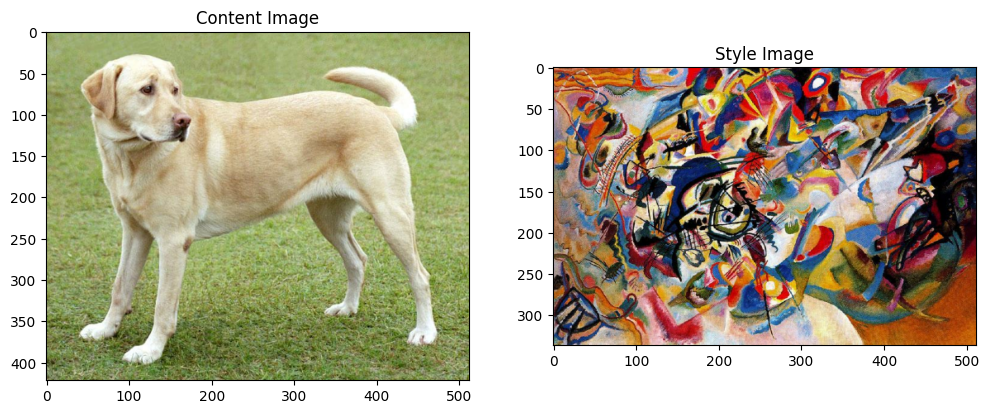

In [399]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## 대량 분류 모델 불러오기

* 예시에서 사용한 모델 : VGG-19
    * VGG-19는 19개 계층으로 구성된 컨벌루션 신경망
    * ImageNet 데이터베이스의 1백만 개가 넘는 영상에 대해 훈련된 신경망의 사전 훈련된 버전을 불러올 수 있음
    * 사전 훈련된 신경망은 1,000가지의 사물 범주로 분류할 수 있음

* 이 외의 모델 보기
![model graph](https://kr.mathworks.com/help/deeplearning/ug/pretrained_20b.png)

In [400]:
# vgg19로 고양이 사진 predict
x = tfka.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tfka.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
print(prediction_probabilities.shape)

predicted_top_5 = tfka.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

(1, 1000)


[('Labrador_retriever', 0.49317187),
 ('golden_retriever', 0.23665284),
 ('kuvasz', 0.0363575),
 ('Chesapeake_Bay_retriever', 0.024182664),
 ('Greater_Swiss_Mountain_dog', 0.01864606)]

In [401]:
# 분류층을 제외한 모델을 불러오고 각 층의 이름 출력
vgg = tfka.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_91
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


* 이미지의 스타일과 콘텐츠를 섞기 위한 모델의 중간층 선택

In [402]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

모델 중간층 어딘가에서 모델 특성을 추출함 -> 중간층 접근해 입력 이미지의 콘텐츠와 스타일 추출

## * Xception 모델 이용

In [403]:
# +. Xception 모델 이용해보기

x = tf.image.resize(content_image, (299, 299))
xcept = tfka.Xception(include_top=True, weights='imagenet')
prediction_probabilities = xcept(x)
print(prediction_probabilities.shape)

predicted_top_5 = tfka.xception.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

(1, 1000)


[('Labrador_retriever', 0.46484193),
 ('golden_retriever', 0.028777486),
 ('Chesapeake_Bay_retriever', 0.028652567),
 ('kelpie', 0.01954829),
 ('dingo', 0.014783069)]

In [421]:
# 분류층을 제외한 모델을 불러오고 각 층의 이름 출력
xcept = tfka.Xception(include_top=False, weights='imagenet')

style_layers_x = []
print()
for layer in xcept.layers:
  if 'conv2d' in layer.name:
    # style_layers_x.append(layer.name)
    print(layer.name)


conv2d_236
conv2d_237
conv2d_238
conv2d_239


In [416]:
content_layers_x = ['block14_sepconv2_act'] 

# style_layers_x = ['block2_sepconv1',
#                 'block5_sepconv1',
#                 'block8_sepconv1', 
#                 'block11_sepconv1',
#                 'block14_sepconv1']

num_content_layers_x = len(content_layers_x)
num_style_layers_x = len(style_layers_x)


## 모델 만들기

In [417]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tfka.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tfk.Model([vgg.input], outputs)
  return model

In [431]:
def xcept_layers(content_layers_x = False):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained Xception, trained on imagenet data
  xcept = tfka.Xception(include_top=False, weights='imagenet')
  xcept.trainable = False

  if content_layers_x:
    layer_names = content_layers_x
  else:
    layer_names = []
    
  for layer in xcept.layers:
    if 'conv2d' in layer.name:
      layer_names.append(layer.name)
  
  outputs = [xcept.get_layer(name).output for name in layer_names]

  model = tfk.Model([xcept.input], outputs)
  return model

In [432]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean(), end='\n\n')

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.52563
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8774
  mean:  199.82689

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.237
  mean:  230.78094

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.154
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.235
  mean:  59.17949



In [433]:
style_extractor_x = xcept_layers()
style_outputs_x = style_extractor_x(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers_x, style_outputs_x):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean(), end='\n\n')

conv2d_236
  shape:  (1, 83, 127, 128)
  min:  -5921.4673
  max:  5510.61
  mean:  88.85824

conv2d_237
  shape:  (1, 42, 64, 256)
  min:  -5496.2046
  max:  5313.5493
  mean:  -186.70238

conv2d_238
  shape:  (1, 21, 32, 728)
  min:  -3902.6514
  max:  6134.4526
  mean:  -397.33252

conv2d_239
  shape:  (1, 11, 16, 1024)
  min:  -16591.71
  max:  11691.695
  mean:  104.6781



## 스타일 계산
이미지의 스타일은 각 특성 맵의 평균과 피쳐맵들 사이의 상관관계로 설명할 수 있습니다. 이런 정보를 담고 있는 그람 행렬(Gram matrix)은 각 위치에서 특성 벡터(feature vector)끼리의 외적을 구한 후,평균값을 냄으로써 구할 수 있습니다.

`tf.linalg.einsum` 함수를 통해 쉽게 계산

In [425]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## 스타일과 콘텐츠 추출

In [426]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tfka.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [427]:
style_layers_x

['conv2d_236', 'conv2d_237', 'conv2d_238', 'conv2d_239']

In [437]:
class StyleContentModel_x(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel_x, self).__init__()
    self.xcept = xcept_layers(content_layers_x)
    self.style_layers_x = xcept.layers[1:]
    self.content_layers_x = content_layers_x
    self.num_style_layers_x = len(xcept.layers[1:])
    self.xcept.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tfka.xception.preprocess_input(inputs)
    outputs = self.xcept(preprocessed_input)
    style_outputs_x, content_outputs_x = (outputs[:self.num_style_layers_x],
                                      outputs[self.num_style_layers_x:])

    style_outputs_x = [gram_matrix(style_output)
                     for style_output in style_outputs_x]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers_x, content_outputs_x)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers_x, style_outputs_x)}

    return {'content': content_dict, 'style': style_dict}

* 이미지가 입력으로 주어졌을 때 스타일레이어와 콘텐츠레이어에 대한 그람 행렬 출력

In [435]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0055226446
    max:  28014.568
    mean:  263.7903

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.54
    mean:  9100.951

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.56
    mean:  7660.9775

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320503.5
    mean:  134288.86

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.24
    mean:  1487.0376

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8809
    mean:  13.764149


In [438]:
extractor_x = StyleContentModel_x(style_layers_x, content_layers_x)

results_x = extractor_x(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results_x['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results_x['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:


TypeError: '<' not supported between instances of 'BatchNormalization' and 'Conv2D'

## 경사하강법 실행

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
style_targets_x = extractor_x(style_image)['style']
content_targets_x = extractor_x(content_image)['content']

image = tf.Variable(content_image)
image_x = tf.Variable(content_image)

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

def style_content_loss_x(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets_x[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers_x

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets_x[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers_x
    loss = style_loss + content_loss
    return loss

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

@tf.function()
def train_step_x(image):
  with tf.GradientTape() as tape:
    outputs_x = extractor_x(image)
    loss_x = style_content_loss_x(outputs_x)

  grad_x = tape.gradient(loss_x, image)
  opt.apply_gradients([(grad_x, image)])
  image.assign(clip_0_1(image))

In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 50

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 50

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step_x(image_x)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image_x))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

## 총 변위 손실

* 많은 고주파 아티팩(high frequency artifact)가 생겨남
* 변형된 오차값을 *총 변위 손실(total variation loss)*라고 한다
* 레귤러리제이션(regularization) 항을 추가

In [ ]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

In [ ]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

In [ ]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image_x)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

In [ ]:
tf.image.total_variation(image).numpy(), tf.image.total_variation(image_x).numpy()

## 다시 최적화하기

In [ ]:
total_variation_weight=30

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

@tf.function()
def train_step_x(image):
  with tf.GradientTape() as tape:
    outputs_x = extractor_x(image)
    loss_x = style_content_loss_x(outputs_x)
    loss_x += total_variation_weight*tf.image.total_variation(image)


  grad_x = tape.gradient(loss_x, image)
  opt.apply_gradients([(grad_x, image)])
  image.assign(clip_0_1(image))

In [ ]:
image = tf.Variable(content_image)
image_x = tf.Variable(content_image)

In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [ ]:
import time
start = time.time()

epochs = 2
steps_per_epoch = 50

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step_x(image_x)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image_x))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))